In [1]:
%matplotlib notebook
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm
sys.path.append('/root/cAAE')

import torch.nn as nn
import torch
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

from model.tools.config import Config, read_conf
from model.train import train
from model.test import test, test_show
config = read_conf(f'/root/cAAE/config/{os.environ["CONFIG_NAME"]}.json')

In [2]:
load_path = '/root/weights'
config.struct.name = 'AAE'
test(config, load_path)

[Cuda: True]


Testing:   0%|          | 0/35 [00:00<?, ?it/s]


KeyboardInterrupt: 

[Cuda: True]
tumor iou: 0.4516128897666931


<IPython.core.display.Javascript object>


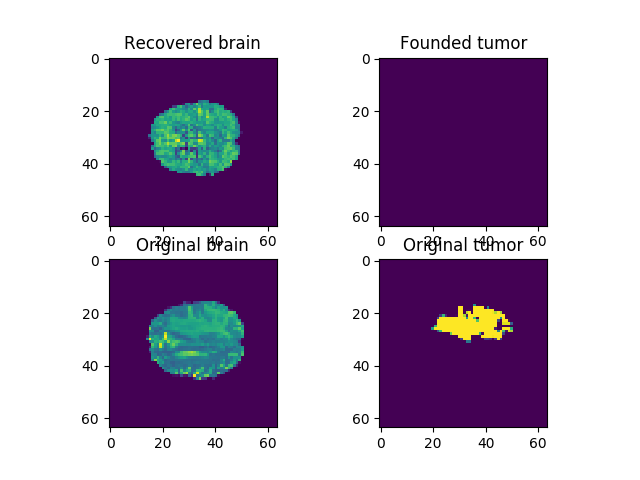

In [3]:
load_path = '/root/weights'
config.struct.name = 'AAE'
test_show(config, load_path, idx=10)

In [26]:
from model.generator import generator, net
dataset = generator(config, train_flg=False)
config.transforms += {'img_shape': dataset.get_img_shape()}
config.struct.name = 'ResDCGAN'
model = net[config.struct.name](config, train_flg=False)

[Cuda: True]


In [27]:
load_path = '/root/weights'
model.encoder.load_state_dict(torch.load(os.path.join(load_path, f'encoder_{model.name}')))
model.decoder.load_state_dict(torch.load(os.path.join(load_path, f'decoder_{model.name}')))
model.discriminator.load_state_dict(torch.load(os.path.join(load_path, f'discriminator_{model.name}')))

<All keys matched successfully>

In [37]:
idx=11
acc=0.1
test_person = dataset.get_person(idx)
recovered_brain, restore_tumor = model.recover(test_person, dataset.transform, acc)

In [38]:
person = test_person
transform = dataset.transform

<IPython.core.display.Javascript object>


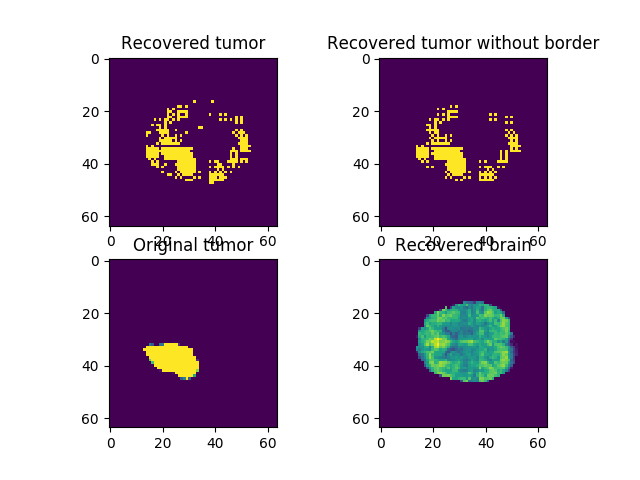

Text(0.5, 1.0, 'Recovered brain')

In [39]:
def del_border(tumor):
    tk = config.test.thickness
    cent = tumor[:, tk:-tk, tk:-tk] > 0
    left = tumor[:, :-2*tk, 2:-2] > 0
    right = tumor[:, 2*tk:, 2:-2] > 0
    top = tumor[:, 2:-2, 2*tk:] > 0
    down = tumor[:, 2:-2, :-2*tk] > 0
    tumor[:, tk:-tk, tk:-tk] = (cent & (left | right) & (top | down))#.type(config.Tensor)
    return tumor

n = int(recovered_brain.shape[0] * 2 / 3)
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(restore_tumor[n, :, :])
axs[0, 0].set_title('Recovered tumor')
axs[0, 1].imshow(del_border(restore_tumor.clone())[n, :, :])
axs[0, 1].set_title('Recovered tumor without border')
axs[1, 0].imshow(person.get_tumor(transform)[n, :, :])
axs[1, 0].set_title('Original tumor')
axs[1, 1].imshow(recovered_brain[n, :, :])
axs[1, 1].set_title('Recovered brain')

In [67]:
a = del_border(restore_tumor.clone())#[n, :, :]
b = person.get_tumor(transform)#[n, :, :]